# Modeling
- Logistic Regression, Random forest and XGBoost were built to do the prediction
- We use the models to predict if a horse is the top 3 winner
- For each model, we preform Gridsearch, and optimization
- At last, we choose the model with the best ROC and then proceed to SHAP explaination

In [20]:
# This code imports some libraries that you will need.
# Python ≥3.5 is required

import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np


# Pandas for overview
import pandas as pd


# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#models
from sklearn.svm import SVC
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from scipy.stats import randint as sp_randint
from sklearn.ensemble import BaggingClassifier,VotingClassifier, AdaBoostClassifier, StackingClassifier, RandomForestClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
# from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# Plot setup
import matplotlib as plt

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [21]:
# load the preprocessed data
df_runs_processed = pd.read_csv("all_runs_processed.csv")
df_runs_processed.head(2)


,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,...,all_runs_finished_position,most_frequent_finish,top_3_most_frequent_finish,best_3_values,top_3_prob,average_rank,is_top_3,Top3Finishes,jockey_total_races,jockey_placement_perc
0,0,1,3917,10,0.0,8.00,3,AUS,3,60,...,"[12, 7, 8, 9, 6, 11, 11, 12, 12, 12, 8, 12, 10...",12,"12,8,7","[1, 2, 3]",0.2000,7.566667,0,1811,4719,38.376775
1,0,2,2157,8,0.0,5.75,3,NZ,3,60,...,"[8, 9, 11, 12, 9, 10, 2, 9, 10, 12, 8, 10, 10,...",10,"10,8,9","[1, 2, 3]",0.1875,7.937500,0,509,1893,26.888537


In [22]:
print(df_runs_processed.shape)
print(df_runs_processed.columns)

(79447, 57)
Index(['race_id', 'horse_no', 'horse_id', 'result', 'won', 'lengths_behind',
       'horse_age', 'horse_country', 'horse_type', 'horse_rating',
       'horse_gear', 'declared_weight', 'actual_weight', 'draw',
       'position_sec1', 'position_sec2', 'position_sec3', 'position_sec4',
       'position_sec5', 'position_sec6', 'behind_sec1', 'behind_sec2',
       'behind_sec3', 'behind_sec4', 'behind_sec5', 'behind_sec6', 'time1',
       'time2', 'time3', 'time4', 'time5', 'time6', 'finish_time', 'win_odds',
       'place_odds', 'jockey_id', 'venue', 'config', 'surface', 'distance',
       'going', 'horse_ratings', 'prize', 'race_class', 'horse_place_perc',
       'jockey_place_perc', 'trainer_place_perc', 'all_runs_finished_position',
       'most_frequent_finish', 'top_3_most_frequent_finish', 'best_3_values',
       'top_3_prob', 'average_rank', 'is_top_3', 'Top3Finishes',
       'jockey_total_races', 'jockey_placement_perc'],
      dtype='object')


# Create train test data

In [23]:
# method one
import pandas as pd
from sklearn.model_selection import train_test_split

# select the features and possible targets for classification modeling
df_selected_modeling = df_runs_processed[['race_id', 'horse_no', 'horse_id','won','is_top_3', 'horse_age',
        'horse_type', 'horse_gear',
       'declared_weight', 'actual_weight', 'draw', 'win_odds',
       'place_odds', 'venue', 'config', 'surface', 'distance', 'going',
       'race_class', 'horse_place_perc', 'jockey_place_perc',
       'trainer_place_perc', 'average_rank','jockey_placement_perc','Top3Finishes']] # Replace with your actual feature columns

#y_1 = df_runs_processed['won']  # Replace with your actual target column
#y_2= df_runs_processed['top_3_prob']
#y_3= df_runs_processed['result']

# split the data into training ,validation ,testing 7:3
train_set, bigtest_set = train_test_split(df_selected_modeling, test_size = 0.3, random_state=42)
val_set,test_set = train_test_split(bigtest_set, test_size=0.5, random_state=42)


In [24]:
# training
X_train = train_set.drop(['won','is_top_3'],axis=1)
y_train = train_set['is_top_3']

# validation
X_val = val_set.drop(['won','is_top_3'],axis=1)
y_val = val_set['is_top_3']

# test
X_test = test_set.drop(['won','is_top_3'],axis=1)
y_test = test_set['is_top_3']


#Verify the size and label distribution in each dataset.

print("Training dataset size:",y_train.shape[0])
print("Training dataset distribution:\n", y_train.value_counts())

print("Validation dataset size:",y_val.shape[0])
print("Validation dataset distribution:\n", y_val.value_counts())

print("Test dataset size: ",y_test.shape[0])
print("Test dataset distribution:\n ", y_test.value_counts())

Training dataset size: 55612
Training dataset distribution:
 0    42237
1    13375
Name: is_top_3, dtype: int64
Validation dataset size: 11917
Validation dataset distribution:
 0    9114
1    2803
Name: is_top_3, dtype: int64
Test dataset size:  11918
Test dataset distribution:
  0    9029
1    2889
Name: is_top_3, dtype: int64


## Logistic Regression

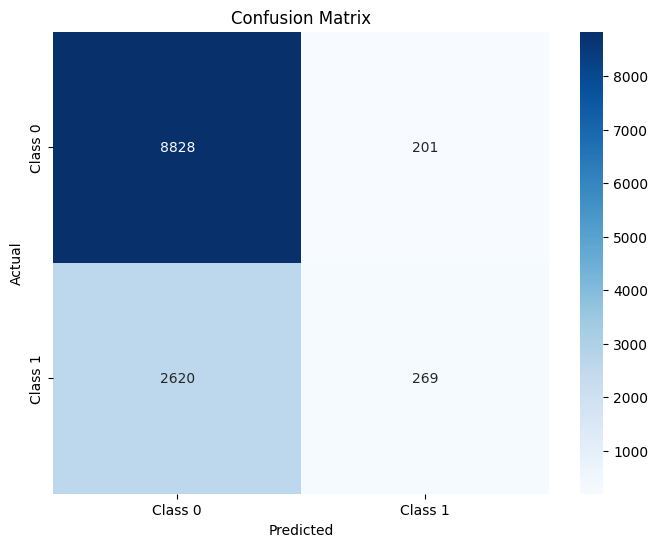

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix

# Assuming X_train, X_test, y_train, y_test are already defined

# Create a Logistic Regression model
logistic_regression_model = LogisticRegression()

# Perform cross-validation and get predicted labels
y_pred_cv = cross_val_predict(logistic_regression_model, X_train, y_train, cv=5)

# Fit the model on the training data
logistic_regression_model.fit(X_train, y_train)

# Get predicted labels on the test data
y_pred = logistic_regression_model.predict(X_test)

# Plot confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


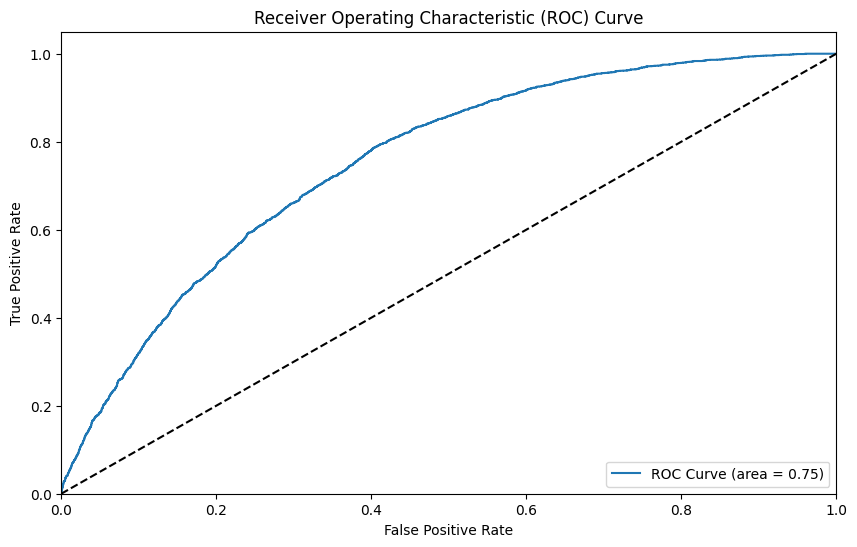

              precision    recall  f1-score       support
Class 0        0.771139  0.977738  0.862236   9029.000000
Class 1        0.572340  0.093112  0.160167   2889.000000
accuracy       0.763299  0.763299  0.763299      0.763299
macro avg      0.671740  0.535425  0.511201  11918.000000
weighted avg   0.722949  0.763299  0.692050  11918.000000


In [26]:

from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Assuming y_test and y_pred are defined from previous code

# Calculate F1-score, recall, and precision
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)
classification_df = pd.DataFrame(classification_rep).transpose()

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, logistic_regression_model.predict_proba(X_test)[:, 1])

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logistic_regression_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the table
print(classification_df)


In [27]:
# Calculate precision
precision = metrics.precision_score(y_test, y_pred)

# Calculate recall
recall = metrics.recall_score(y_test, y_pred)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, logistic_regression_model.predict_proba(X_test)[:, 1])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROC AUC: {roc_auc}')

Precision: 0.5723404255319149
Recall: 0.09311180339217723
ROC AUC: 0.7528698055774363


In [28]:
# SHAP values
import shap

# fit the model
logistic_regression_model.fit(X_train, y_train)

# Create object that can calculate shap values
explainer = shap.Explainer(logistic_regression_model.predict, X_test)

# Calculate Shap values
shap_values = explainer(X_test)

PermutationExplainer explainer: 11919it [02:48, 66.68it/s]                            


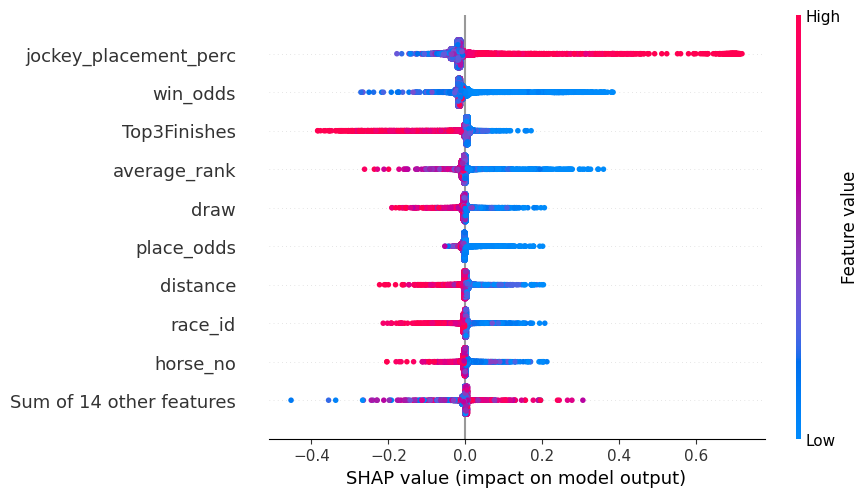

In [29]:
shap.plots.beeswarm(shap_values)

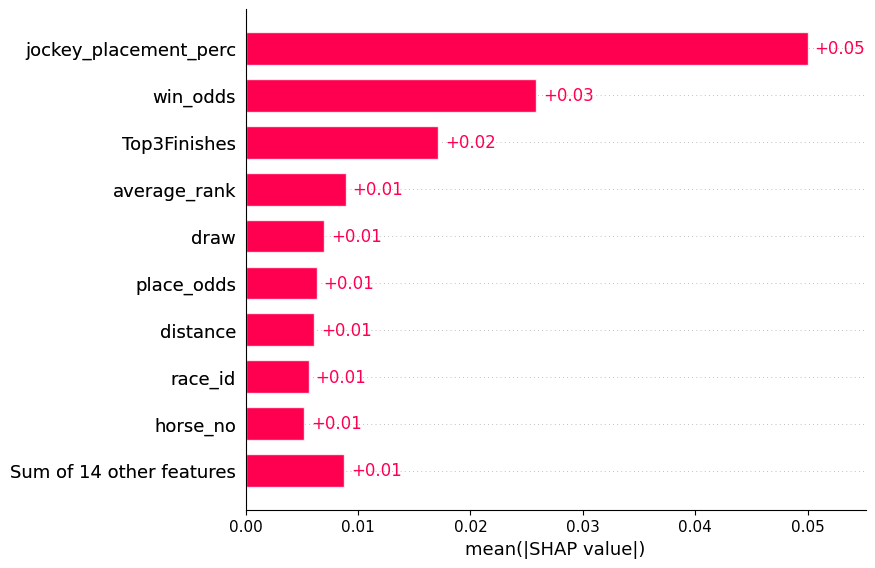

In [30]:
shap.plots.bar(shap_values)

# Random Forest Classifer

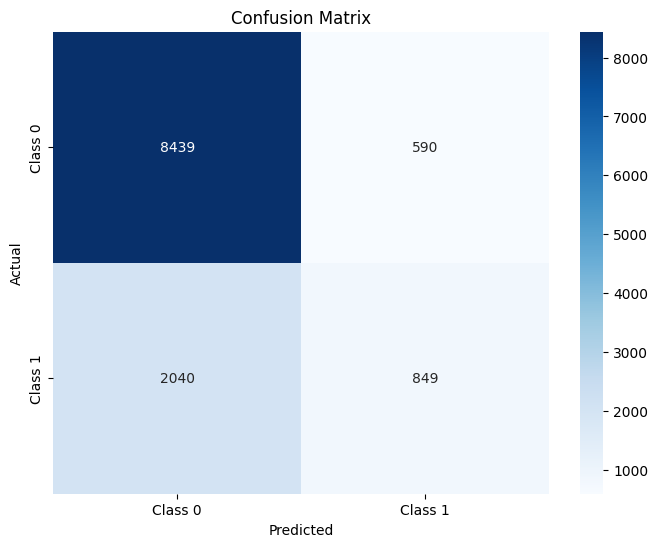

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix

# Assuming X_train, X_test, y_train, y_test are already defined

# Create a Random Forest model
random_forest_model = RandomForestClassifier()

# Perform cross-validation and get predicted labels
y_pred_cv = cross_val_predict(random_forest_model, X_train, y_train, cv=5)

# Fit the model on the training data
random_forest_model.fit(X_train, y_train)

# Get predicted labels on the test data
y_pred = random_forest_model.predict(X_test)

# Plot confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


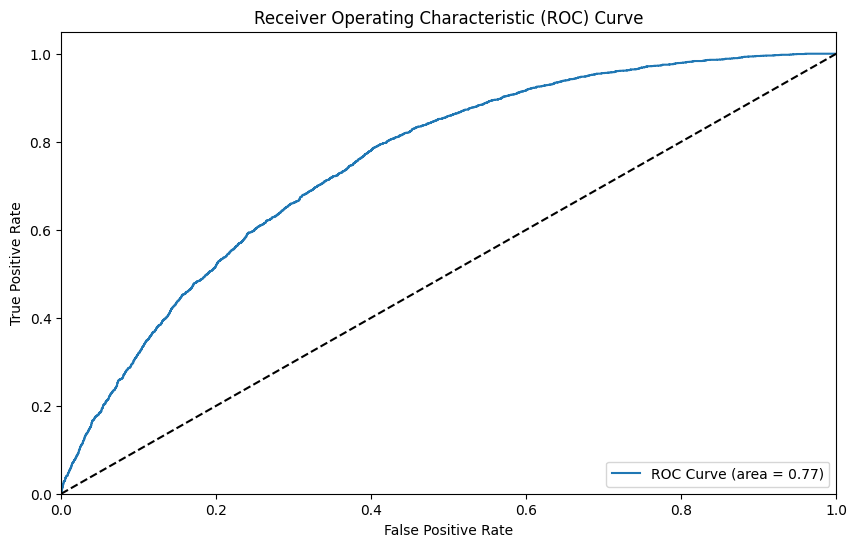

              precision    recall  f1-score       support
Class 0        0.805325  0.934655  0.865184   9029.000000
Class 1        0.589993  0.293873  0.392329   2889.000000
accuracy       0.779325  0.779325  0.779325      0.779325
macro avg      0.697659  0.614264  0.628756  11918.000000
weighted avg   0.753127  0.779325  0.750561  11918.000000


In [32]:

# Calculate F1-score, recall, and precision
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)
classification_df = pd.DataFrame(classification_rep).transpose()

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, random_forest_model.predict_proba(X_test)[:, 1])

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logistic_regression_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the table
print(classification_df)

In [33]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Assuming y_test and y_pred are defined

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, random_forest_model.predict_proba(X_test)[:, 1])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROC AUC: {roc_auc}')


Precision: 0.5899930507296733
Recall: 0.29387331256490135
ROC AUC: 0.7673530209051783


## XGBoost

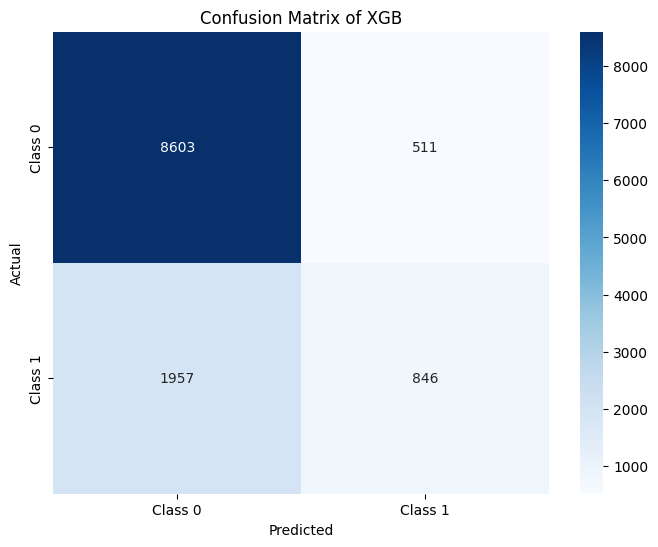

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Assuming X_train, X_test, y_train, y_test are already defined

# Create an XGBoost model
xgb_model = XGBClassifier()

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

# Get predicted labels on the test data
y_pred_xgb = best_xgb_model.predict(X_val)

# Plot confusion matrix for test set
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of XGB')
plt.show()

# Calculate F1-score, recall, and precision
classification_rep_xgb = classification_report(y_val, y_pred_xgb, target_names=['Class 0', 'Class 1'], output_dict=True)
classification_df_xgb = pd.DataFrame(classification_rep_xgb).transpose()

# Now you can interpret the results as explained in the previous response.


In [35]:
print(best_xgb_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [36]:
print(classification_df_xgb)

              precision    recall  f1-score       support
Class 0        0.814678  0.943932  0.874555   9114.000000
Class 1        0.623434  0.301819  0.406731   2803.000000
accuracy       0.792901  0.792901  0.792901      0.792901
macro avg      0.719056  0.622876  0.640643  11917.000000
weighted avg   0.769695  0.792901  0.764518  11917.000000


In [37]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Assuming y_test and y_pred are defined

# Calculate precision
precision = metrics.precision_score(y_val, y_pred_xgb)

# Calculate recall
recall = metrics.recall_score(y_val, y_pred_xgb)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, best_xgb_model.predict_proba(X_val)[:, 1])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROC AUC: {roc_auc}')


Precision: 0.6234340456890199
Recall: 0.3018194791295041
ROC AUC: 0.7933543021204201


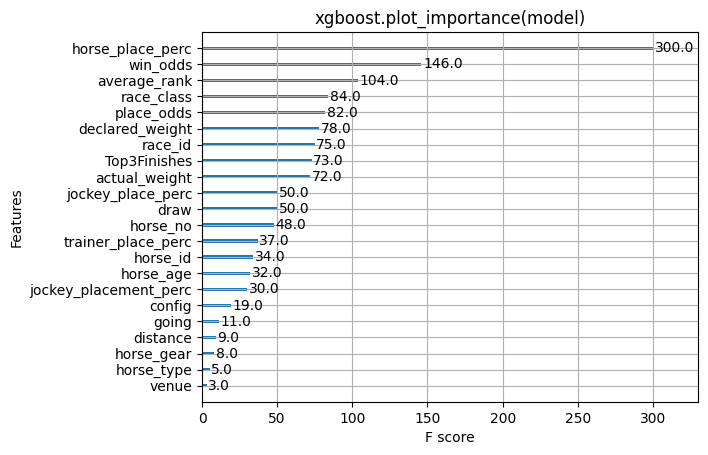

In [43]:
import xgboost
xgboost.plot_importance(best_xgb_model)
plt.title("xgboost.plot_importance(model)")
plt.show()

## SHAP explaination with the best model
-best_xgb_model is the best model

In [38]:
# SHAP values
import shap

# fit the model
best_xgb_model.fit(X_train, y_train)

# Create object that can calculate shap values
explainer_xgb = shap.Explainer(best_xgb_model.predict, X_val)

# Calculate Shap values
shap_values_xgb = explainer_xgb(X_val)

PermutationExplainer explainer: 11918it [06:18, 30.64it/s]                           


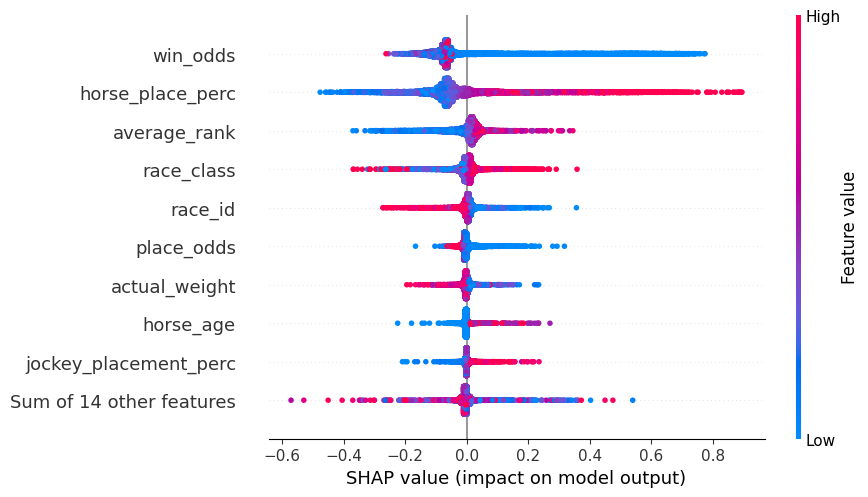

In [39]:
shap.plots.beeswarm(shap_values_xgb)

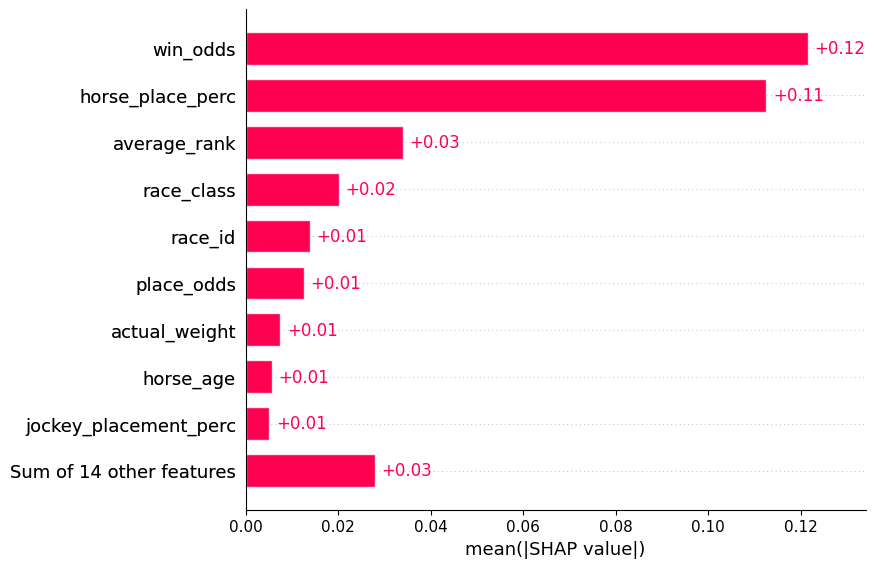

In [41]:
shap.plots.bar(shap_values_xgb)

In [53]:
names = X_train.columns[0:]
print(names)

Index(['race_id', 'horse_no', 'horse_id', 'horse_age', 'horse_type',
       'horse_gear', 'declared_weight', 'actual_weight', 'draw', 'win_odds',
       'place_odds', 'venue', 'config', 'surface', 'distance', 'going',
       'race_class', 'horse_place_perc', 'jockey_place_perc',
       'trainer_place_perc', 'average_rank', 'jockey_placement_perc',
       'Top3Finishes'],
      dtype='object')


In [79]:
print(xgb_tree_explainer.expected_value)
print(xgb_tree_shap_values.shape)
print(X_val.shape)
print(names.shape)
print(xgb_tree_shap_values[0, :])

-1.1752193
(11917, 23)
(11917, 23)
(23,)
[ 1.1860272e-01 -5.0763138e-02 -3.6766834e-03 -1.6458815e-02
 -6.9957093e-04 -1.2290697e-02 -1.3832426e-02 -9.4250321e-02
  9.3157880e-02 -3.3394098e-01  4.4975914e-02  3.8162695e-04
  2.6163664e-03  0.0000000e+00  2.1612269e-03 -4.5280205e-04
  2.0849422e-01 -4.7070470e+00  1.5156830e-02 -2.4347413e-02
  3.2764193e-01 -6.7954501e-03 -7.3673941e-02]


In [75]:
print(xgb_tree_explainer.expected_value)
print(xgb_tree_shap_values[0].shape)


-1.1752193
(23,)


In [81]:
shap.initjs()
shap.force_plot(xgb_tree_explainer.expected_value, xgb_tree_shap_values[0, :], X_train.iloc[0, :])

In [82]:
shap.force_plot(
    xgb_tree_explainer.expected_value, xgb_tree_shap_values[:1000, :], X_train.iloc[:1000, :]
)
